# SWECRIS DBstep 1: Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [2]:
import re
import string
import stanza
from spacy_stanza import StanzaLanguage
import pprint

- Global variables

In [3]:
svStanzaDownloaded = False
snlpInitialized = False
nlpStanza = {}

pp = pprint.PrettyPrinter(indent=2, width=200)

categories = []

- Needed to be able to run on __gpu (cuda)__

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

- Either load data from local drive or download first from google drive, if within docker container
    check this great link [__Colab__](https://colab.research.google.com/)  
    the alternative is [__Binder__](https://mybinder.org) though there is no gpu there

In [5]:
table_name = 'swecris'
db_path = 'db/categorised_swecris.sqlite'

if not Path(db_path).is_file():
    gdd.download_file_from_google_drive(
        file_id='1O8A7QOpynNTsblDHve0R7xD0CQFQzxrx',
        dest_path=db_path,
    )
    print('Dowloaded from google drive')
db_path = 'sqlite:///' + db_path

In [6]:
engine = create_engine(db_path, echo=True)
data_df = pd.read_sql_table(table_name, engine)
data_df.set_index('title', inplace=True, drop=True)

2020-12-10 00:35:14,152 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-10 00:35:14,153 INFO sqlalchemy.engine.base.Engine ()
2020-12-10 00:35:14,156 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-10 00:35:14,156 INFO sqlalchemy.engine.base.Engine ()
2020-12-10 00:35:14,159 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-12-10 00:35:14,161 INFO sqlalchemy.engine.base.Engine ()
2020-12-10 00:35:14,163 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2020-12-10 00:35:14,164 INFO sqlalchemy.engine.base.Engine ()
2020-12-10 00:35:14,166 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("swecris")
2020-12-10 00:35:14,167 INFO sqlalchemy.engine.base.Engine ()
2020-12-10 00:35:14,172 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION AL

## Data cleaning

1. Clean text round 1
    - transform to lower case
    - replace punctuation with spaces
2. Clean text round 2
    - remove new lines (replace with a single space)
    - remove some punctuation and non-sensical text that was missed in round 1
3. Lemmatize text


### For google
- Needed for JupyterLab within docker container on google cloud, by default these packages are not installed
- On binder packages are preinstalled by listing them in the `requirements.txt`

In [7]:
!pip install stanza
!pip install spacy-stanza

In [8]:
def initStanzaPipeline(lang):
    downloadStanza(lang)
    global snlpInitialized
    global nlpStanza
    if not snlpInitialized:
        snlp = stanza.Pipeline(lang=lang)
        nlpStanza['snlp'] = StanzaLanguage(snlp)
        snlpInitialized = True

In [9]:
def removeNewlines(text):
    text = re.sub(r'\\r\\n', ' ', text)
    text = re.sub(r'\\n', ' ', text)
    return ' '.join(text.split())

In [10]:
def clean_text_round1(text):
    """First round of cleaning.

    Make text lowercase, remove text in square brackets,
    remove punctuation and remove words containing numbers.
    """
    text = removeNewlines(text)
    text = text.lower()
    text = re.sub(r'|[.*?]|', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [16]:
data_clean = pd.DataFrame(data_df.abstract.apply(clean_text_round1))

In [17]:
print(data_clean.abstract)

title
The Agenda 2030 Compass Methodology and toolbox for strategic decision making (2030Compass)                syfte och mål syftet är att utveckla agenda  d...
IP CHECK                                                                                                   syfte och mål vi har lyckats skapa processer o...
Innovativa lösningar för äldres oberoende                                                                  syfte och mål målet med projektet är att utvec...
Arena Research2Business                                                                                    syfte och mål stärka kommersiell samverkan och...
Hollbium AB                                                                                                syfte och mål vårt mål är att tjänstefiera kon...
                                                                                                                                 ...                        
2017 års konferens om Earth System Governance       

In [18]:
def clean_text_round2(text):
    """Second round of cleaning.

    Get rid of some additional punctuation and non-sensical text
    that was missed the first time around.
    """
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[‘’“”…–|-]', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    return text

In [19]:
data_clean = pd.DataFrame(data_clean.abstract.apply(clean_text_round2))

In [20]:
print(data_clean.abstract)

title
The Agenda 2030 Compass Methodology and toolbox for strategic decision making (2030Compass)                syfte och mål syftet är att utveckla agenda dv...
IP CHECK                                                                                                   syfte och mål vi har lyckats skapa processer o...
Innovativa lösningar för äldres oberoende                                                                  syfte och mål målet med projektet är att utvec...
Arena Research2Business                                                                                    syfte och mål stärka kommersiell samverkan och...
Hollbium AB                                                                                                syfte och mål vårt mål är att tjänstefiera kon...
                                                                                                                                 ...                        
2017 års konferens om Earth System Governance       

In [21]:
def downloadStanza(lang):
    # download sv stanza (to avoid downloading it for every doc)
    global svStanzaDownloaded
    if not svStanzaDownloaded:
        stanza.download(lang)
        svStanzaDownloaded = True

In [22]:
def lemmatizeText(text):
    initStanzaPipeline('sv')
    doc = nlpStanza['snlp'](text)
    lemmatized_text = ''
    for token in doc:
        if token.lemma_ == 'all':
            token.lemma_ = 'alla'
        lemmatized_text += token.lemma_ + ' '
    text = lemmatized_text
    return text

In [ ]:
data_clean = pd.DataFrame(data_clean.abstract.apply(lemmatizeText))

2020-12-10 00:37:34 INFO: Downloading default packages for language: sv (Swedish)...
2020-12-10 00:37:35 INFO: File exists: /Users/nesko/stanza_resources/sv/default.zip.
2020-12-10 00:37:39 INFO: Finished downloading models and saved to /Users/nesko/stanza_resources.
2020-12-10 00:37:39 INFO: Loading these models for language: sv (Swedish):
| Processor | Package   |
-------------------------
| tokenize  | talbanken |
| pos       | talbanken |
| lemma     | talbanken |
| depparse  | talbanken |

2020-12-10 00:37:39 INFO: Use device: cpu
2020-12-10 00:37:39 INFO: Loading: tokenize
2020-12-10 00:37:39 INFO: Loading: pos
2020-12-10 00:37:40 INFO: Loading: lemma
2020-12-10 00:37:40 INFO: Loading: depparse
2020-12-10 00:37:42 INFO: Done loading processors!


## CoutVectrizer

- default ngram_range(1,1) = __unigrams__
- for unigrams and __bigrams__ set ngram_range(1,2)

In [ ]:
STOP_WORDS = set(
    """
aderton adertonde adjö aldrig allas allt alltid alltså än andra andras
annan annat ännu artonde arton åtminstone att åtta åttio åttionde åttonde av
även

båda bådas bakom bara bäst bättre behöva behövas behövde behövt beslut beslutat
beslutit bland blev bli blir blivit bort borta bra

då dag dagar dagarna dagen där därför de del delen dem den deras dess det detta
dig din dina dit ditt dock du

efter eftersom elfte eller elva en enkel enkelt enkla enligt er era ert ett
ettusen

få fanns får fått fem femte femtio femtionde femton femtonde fick fin finnas
finns fjärde fjorton fjortonde fler flera flesta följande för före förlåt förra
första fram framför från fyra fyrtio fyrtionde

gå gälla gäller gällt går gärna gått genast genom gick gjorde gjort god goda
godare godast gör göra gott

ha hade haft han hans har här heller hellre helst helt henne hennes hit hög
höger högre högst hon honom hundra hundraen hundraett hur

i ibland idag igår igen imorgon in inför inga ingen ingenting inget innan inne
inom inte inuti

ja jag jämfört

kan kanske knappast kom komma kommer kommit kr kunde kunna kunnat kvar

länge längre långsam långsammare långsammast långsamt längst långt lätt lättare
lättast legat ligga ligger lika likställd likställda lilla lite liten litet

man många måste med mellan men mer mera mest mig min mina mindre minst mitt
mittemot möjlig möjligen möjligt möjligtvis mot mycket

någon någonting något några när nästa ned nederst nedersta nedre nej ner ni nio
nionde nittio nittionde nitton nittonde nödvändig nödvändiga nödvändigt
nödvändigtvis nog noll nr nu nummer

och också ofta oftast olika olikt om oss

över övermorgon överst övre

på

rakt rätt redan

så sade säga säger sagt samma sämre sämst sedan senare senast sent sex sextio
sextionde sexton sextonde sig sin sina sist sista siste sitt sjätte sju sjunde
sjuttio sjuttionde sjutton sjuttonde ska skall skulle slutligen små smått snart
som stor stora större störst stort

tack tidig tidigare tidigast tidigt till tills tillsammans tio tionde tjugo
tjugoen tjugoett tjugonde tjugotre tjugotvå tjungo tolfte tolv tre tredje
trettio trettionde tretton trettonde två tvåhundra

under upp ur ursäkt ut utan utanför ute

vad vänster vänstra var vår vara våra varför varifrån varit varken värre
varsågod vart vårt vem vems verkligen vi vid vidare viktig viktigare viktigast
viktigt vilka vilken vilket vill
""".split()
)

In [ ]:
common_stopwords = [
    'både',
    'först',
    'ge',
    'minska',
    'samt',
    'se',
    'synnerhet',
    'sätt',
    'ta',
    'vara',
    'år',
    'öka'
    ]

extra_stopwords = [
    'ansökan', 'avhandling',
    'bakgrund',
    'disputationsämne',
    'huvudsyfte',
    'mål', 'målsättning',
    'konferens',
    'projekt',
    'resebidrag',
    'syfte',
    'undertecknad'
    ]

In [ ]:
STOP_WORDS = STOP_WORDS.union(common_stopwords)
STOP_WORDS = STOP_WORDS.union(extra_stopwords)

In [ ]:
# cv = CountVectorizer(stop_words=sw.STOP_WORDS, ngram_range=(1, 2), max_features=1000)
cv = CountVectorizer(stop_words=STOP_WORDS, max_features=1000)

In [7]:
data_cv = cv.fit_transform(data_clean.abstract)

In [ ]:
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm = data_dtm.transpose()

__Find the top 30 words within each goal__

In [8]:
top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending=False).head(30)
    top_dict[c] = list(zip(top.index, top.values))

__Print the top 15 words within each goal__

In [9]:
for name, top_words in top_dict.items():
    print()
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')


fattigdom, människa, alla, ekonomisk, sprida, svår, extrem, köpa, utbildning, statlig, social, bidra, form, kunskap
---

mat, jordbruk, tillgång, hållbar, alla, människa, inklusive, livsmedelsproduktion, internationell, donera, behövande, värld, hung, kommun
---

hälsa, alla, sjukdom, människa, dödsfall, förebygga, sjukvård, antal, sjukhus, tillgång, läkemedel, förorening, drogmissbruk, grundläggande
---

utbildning, alla, kunskap, skola, värld, tillgång, kvalitet, människa, utveckling, säkerställa, engelsk, förskola, hållbar, antal
---

kvinna, alla, flicka, jämställdhet, möjlighet, röst, hörd, form, tillgång, våld, diskriminering, avskaffa, främja, visa
---

vatten, sanitet, tillgång, alla, människa, toalett, säker, förbättra, drabba, använda, värld, hållbar, organisation, uppmärksam
---

energi, använda, alla, elektricitet, tillgång, förnyba, teknik, ren, el, återvinna, elräkning, batteri, energieffektivitet, energitjänster
---

företag, främja, ekonomisk, människa, alla, hållbar, 

## WordCloud

In [10]:
wc = WordCloud(stopwords=sw.STOP_WORDS, background_color="white",
               colormap="Dark2", max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [30, 12]

__Create subplots for each Global Goal__

In [11]:
names = data_clean.index.values.tolist()

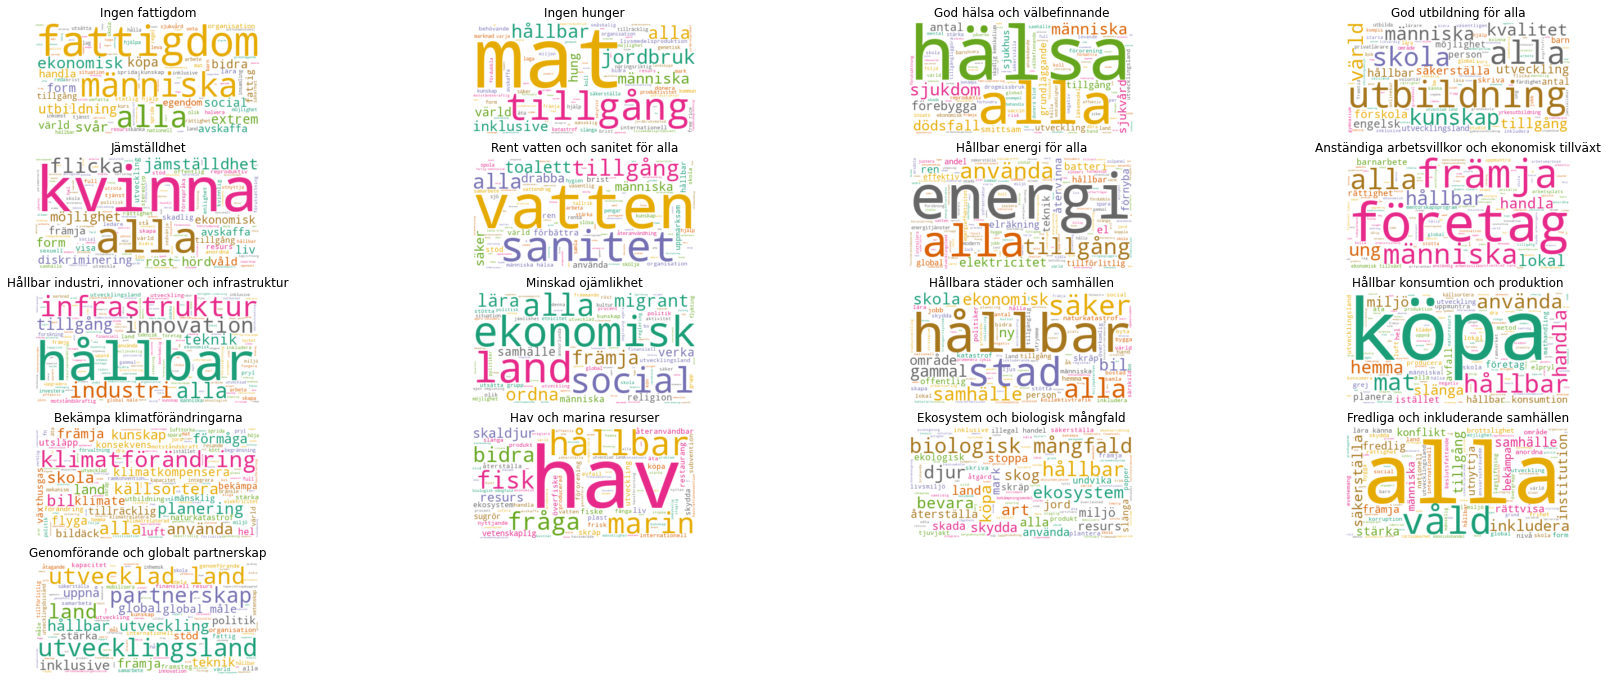

In [12]:
for index, name in enumerate(data_dtm.columns):
    wc.generate(data_clean.Description[name])

    plt.subplot(5, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(names[index])

plt.show()